In [1]:
# import uproot
import awkward as ak
import numpy as np
import time
# import coffea

# print(coffea.__version__)
from coffea import util
from coffea.nanoevents import NanoEventsFactory, NanoAODSchema
import mplhep as hep

In [2]:
# Read in files
import pandas as pd

#if using LPC dask or running locally use 'root://cmsxrootd.fnal.gov/'
#is using coffea casa use 'root://xcache/'
redirector = 'root://cmsxrootd.fnal.gov/'

def importData(jsonFile, testing = True):
    df = pd.read_json(jsonFile)
    dict = df['JetHT_data'][0]
    if testing:
        for key in dict:
            dict[key][0] = redirector + dict[key][0]
    else:
        for key in dict:
            for i in range(len(dict[key])):
                dict[key][i] = redirector + dict[key][i]
    print(dict)
    return dict

files = importData('datasets_JetHT_UL_NANOAOD.json')
    
#SET UP DASK CLIENT

from dask.distributed import Client

{'/JetHT/Run2016F-UL2016_MiniAODv2_NanoAODv9-v1/NANOAOD': ['root://cmsxrootd.fnal.gov//store/data/Run2016F/JetHT/NANOAOD/UL2016_MiniAODv2_NanoAODv9-v1/70000/4CF30F76-B083-4946-9F06-053FE8395464.root', '/store/data/Run2016F/JetHT/NANOAOD/UL2016_MiniAODv2_NanoAODv9-v1/70000/D2CF1FA9-3B91-804A-B627-3A53CBB11404.root', '/store/data/Run2016F/JetHT/NANOAOD/UL2016_MiniAODv2_NanoAODv9-v1/70000/D71F5FF4-F277-694A-8663-ED564A617323.root', '/store/data/Run2016F/JetHT/NANOAOD/UL2016_MiniAODv2_NanoAODv9-v1/70000/F77A6FC2-0D11-6445-880B-5B8509DC4AB2.root', '/store/data/Run2016F/JetHT/NANOAOD/UL2016_MiniAODv2_NanoAODv9-v1/70000/F901FFB3-64AA-A349-A162-36D029C626DC.root'], '/JetHT/Run2016H-UL2016_MiniAODv2_NanoAODv9-v1/NANOAOD': ['root://cmsxrootd.fnal.gov//store/data/Run2016H/JetHT/NANOAOD/UL2016_MiniAODv2_NanoAODv9-v1/130000/0290F73B-A51C-A441-AEC1-8429F9CC8AA8.root', '/store/data/Run2016H/JetHT/NANOAOD/UL2016_MiniAODv2_NanoAODv9-v1/130000/06A09125-0C33-E443-999A-B7F34EE9F3EA.root', '/store/data/Run

In [3]:

filename_2016 = '/store/data/Run2016B/JetHT/NANOAOD/ver1_HIPM_UL2016_MiniAODv2_NanoAODv9-v2/2430000/341EF3A8-3C77-8C4F-A0F6-A71CCB9FAF37.root'
filename_2017 = '/store/data/Run2017F/JetHT/NANOAOD/UL2017_MiniAODv2_NanoAODv9-v1/120000/0601305F-2F0F-F04F-B450-97422C843C9F.root'
filename_2018 = '/store/data/Run2018C/JetHT/NANOAOD/UL2018_MiniAODv2_NanoAODv9-v1/130000/0AAA356D-7531-CD40-A4B1-A12F77FF2652.root'
# jetht = uproot.open(redirector + filename_2016)

events = NanoEventsFactory.from_root(redirector + filename_2016, schemaclass=NanoAODSchema).events()
events = events[(ak.num(events.FatJet) >= 2)]
print(events.fields)
print(events.TrigObj.fields)
##### ensure 2 back to back dijets
jet1 = events.FatJet[:,0]
jet2 = events.FatJet[:,1]
        
#### calculate dphi_min
dphi12 = (np.abs(jet1.delta_phi(jet2)) > 2.)
events = events[dphi12]

trigObj = events.TrigObj
print("Number of trig obj before delta R matching = ", ak.count(trigObj.pt))

#### match trigObj to leading fat jet for turn on plots
deltaR  = events.FatJet[:, 0].delta_r(events.TrigObj)
print("Max deltaR value: ", ak.max(deltaR))
print("Min deltaR value: ", ak.min(deltaR))

trigObj_dRmatch = trigObj[deltaR < 0.15]
trigObj = trigObj[trigObj.id == 1]

print("Number of trig obj after id matching = ", ak.count(trigObj.pt))
print("Number of trig obj after delta R matching = ", ak.count(trigObj_dRmatch.pt))
#multiple trigger objects per leading jet?
print("Number of leading fat jets after delta R matching = ", ak.count(events.FatJet[:, 0].pt))


['FsrPhoton', 'OtherPV', 'boostedTau', 'MET', 'HLTriggerFinalPath', 'SoftActivityJetHT', 'SoftActivityJetNjets5', 'IsoTrack', 'FatJet', 'SoftActivityJetHT10', 'PuppiMET', 'CorrT1METJet', 'PPSLocalTrack', 'Photon', 'fixedGridRhoFastjetCentralChargedPileUp', 'Jet', 'fixedGridRhoFastjetCentral', 'SubJet', 'L1PreFiringWeight', 'TkMET', 'L1', 'Muon', 'run', 'ChsMET', 'HLT', 'DeepMETResolutionTune', 'CaloMET', 'fixedGridRhoFastjetCentralCalo', 'luminosityBlock', 'SoftActivityJetHT5', 'PV', 'SoftActivityJetHT2', 'Proton', 'SoftActivityJetNjets2', 'RawPuppiMET', 'fixedGridRhoFastjetAll', 'LowPtElectron', 'Flag', 'fixedGridRhoFastjetCentralNeutral', 'SoftActivityJet', 'event', 'RawMET', 'DeepMETResponseTune', 'SoftActivityJetNjets10', 'Electron', 'HLTriggerFirstPath', 'L1Reco', 'Tau', 'SV', 'TrigObj']
['pt', 'eta', 'phi', 'l1pt', 'l1pt_2', 'l2pt', 'id', 'l1iso', 'l1charge', 'filterBits']
Number of trig obj before delta R matching =  818995
Max deltaR value:  8.527462
Min deltaR value:  0.0
Numb

In [4]:
# from coffea.lookup_tools import extractor
# ext = extractor()
###figure out how to do everything within coffea

In [5]:
#### uproot notation
# jetht.keys()
# uprootevents = jetht['Events']
# uprootevents.keys('HLT_PFJet*')
# uprootevents.keys('FatJet*')
# uprootevents.show()

In [11]:
#TO DO: if statement to add prefix "HLT_" if using uproot --> for now switch to just coffea
#### THESE ARE NOT FINAL VALUES - NEED TO MAKE TURNON PLOTS
trigThresh_2016 = [40, 60, 80, 140, 200, 260, 320, 400, 450, 500]
prescale_2016 = {
    'PFJet40'  : 136006.59,
    'PFJet60'  : 50007.75,
    'PFJet80'  : 13163.18,
    'PFJet140' : 1501.12,
    'PFJet200' : 349.82,
    'PFJet260' : 61.17,
    'PFJet320' : 20.49,
    'PFJet400' : 6.99,
    'PFJet450' : 1.00,
    'PFJet500' : 1.00
            }
tot_lumi_2016 = 36.31
pt_thresh_2016 = {
    'PFJet40'  : 140.,
    'PFJet60'  : 200.,
    'PFJet80'  : 260.,
    'PFJet140' : 350.,
    'PFJet200' : 460.,
    'PFJet260' : 550.,
    'PFJet320' : 650.,
    'PFJet400' : 760.,
    'PFJet450' : 760.,
    'PFJet500' : 760.,
            }
prescale_2017 = {
    'PFJet40'  : 86061.17, 
    'PFJet60'  : 36420.75,    
    'PFJet80'  : 9621.74,    
    'PFJet140' : 1040.40,  
    'PFJet200' : 189.54,      
    'PFJet260' : 74.73,     
    'PFJet320' : 29.49,      
    'PFJet400' : 9.85,       
    'PFJet450' : 3.97,       
    'PFJet500' : 1.00,       
    'PFJet550' : 1.00,
}
tot_lumi_2017 = 41.48
prescale_2018 = {
    'PFJet15'  : 318346231.66,
    'PFJet25'  : 318346231.66,
    'PFJet40'  : 248642.75,
    'PFJet60'  : 74330.16,  
    'PFJet80'  : 11616.52,   
    'PFJet140' : 1231.88,   
    'PFJet200' : 286.14,    
    'PFJet260' : 125.78,     
    'PFJet320' : 32.66,     
    'PFJet400' : 15.83,      
    'PFJet450' : 7.96,      
    'PFJet500' : 1.00,       
    'PFJet550' : 1.00,   
}
tot_lumi_2018 = 59.83

[[218, 205, 228, 199], [257, 249, ... 346, 224, 126, 43.4, 31.5, 46.5, 26.5, 11]]
97558
[850, 874, 494, 286, 280, 843, 372, 1.02e+03, ... 566, 676, 570, 898, 410, 726, 856]
97558
[True, True, True, True, True, True, True, ... True, True, True, True, True, True]
97400
{'PFJet40': <Array [False, False, False, ... False, False] type='97558 * bool[parameters={"_...'>, 'PFJet60': <Array [False, False, False, ... False, False] type='97558 * bool[parameters={"_...'>, 'PFJet80': <Array [False, False, False, ... False, False] type='97558 * bool[parameters={"_...'>, 'PFJet140': <Array [False, False, False, ... False, False] type='97558 * bool[parameters={"_...'>, 'PFJet200': <Array [False, False, False, ... False, False] type='97558 * bool[parameters={"_...'>, 'PFJet260': <Array [False, False, False, ... True, False] type='97558 * bool[parameters={"__...'>, 'PFJet320': <Array [False, False, False, ... True, True] type='97558 * bool[parameters={"__d...'>, 'PFJet400': <Array [False, False, False, 

/opt/conda/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


Basic fit results:  [-8.32813313e-05  5.39828918e+01  1.11387155e+02]
MLE results:  [1.25008129e-07 2.93073376e-11 9.31736827e-12]
Curve_fit:  [-8.32813313e-05  5.39828918e+01  1.11387155e+02]
index:  5  path:  PFJet260
PFJet200
HLT pt cut:  200  L1 pt cut:  260
Length of num: 60  Length of denom:  60
[0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 3.400e+01 1.066e+03
 1.885e+03 1.243e+03 6.810e+02 4.180e+02 2.420e+02 1.300e+02 9.000e+01
 5.100e+01 3.300e+01 2.600e+01 1.500e+01 1.000e+01 1.000e+01 4.000e+00
 6.000e+00 3.000e+00 1.000e+00 0.000e+00 0.000e+00 2.000e+00 1.000e+00
 0.000e+00 0.000e+00 1.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 0.000e+00]
Length of num: 22  Length of denom:  22
Number of bins: 60
Hist(
  StrCategory(['JetHT_

Basic fit results:  [-8.29447562e-04  3.71473614e+02  3.86536879e+01]
MLE results:  [-9.37271094e-07  1.67509103e-08  7.75764588e-05]
Curve_fit:  [-8.29447562e-04  3.71473614e+02  3.86536879e+01]
{'PFJet80': -5324.379382664647, 'PFJet140': 205.93420418846023, 'PFJet200': 237.4591410711655, 'PFJet260': 294.3008496902466, 'PFJet320': 282.31025334236784, 'PFJet400': 399.08517032310556, 'PFJet450': nan, 'PFJet500': 435.94115168191666}


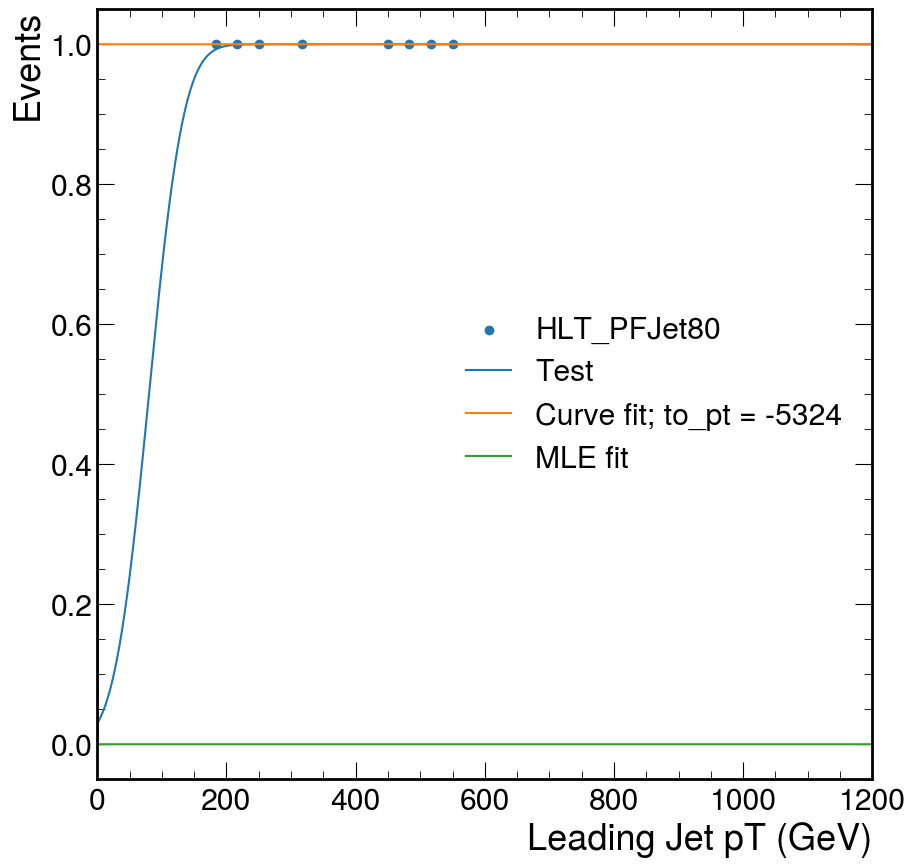

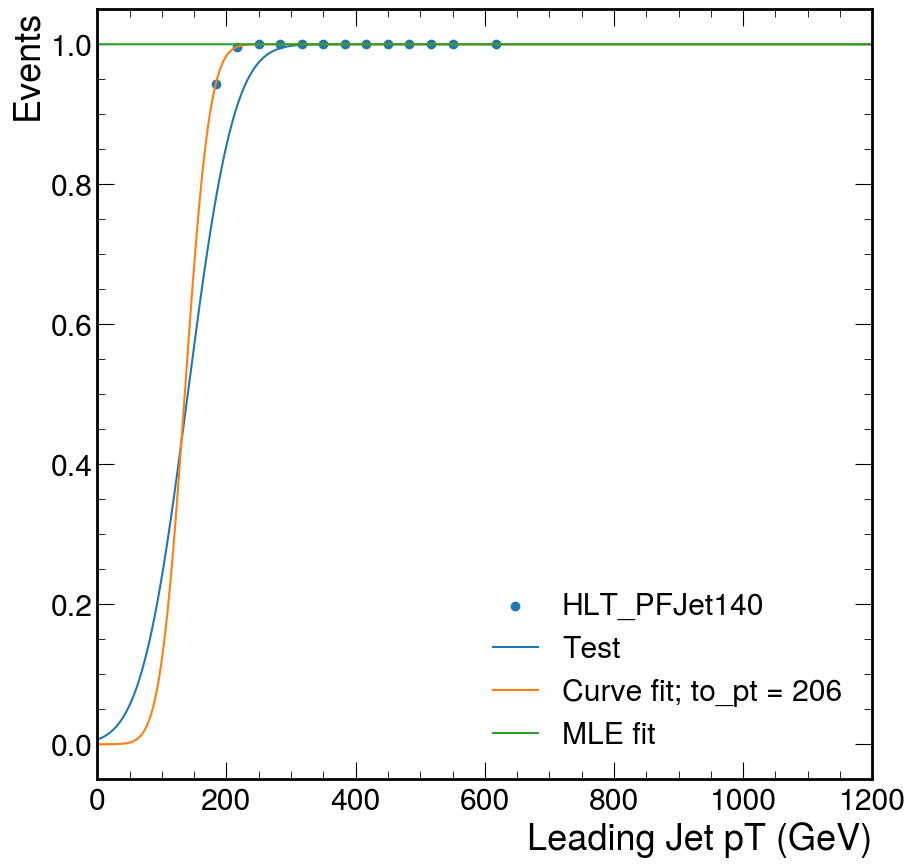

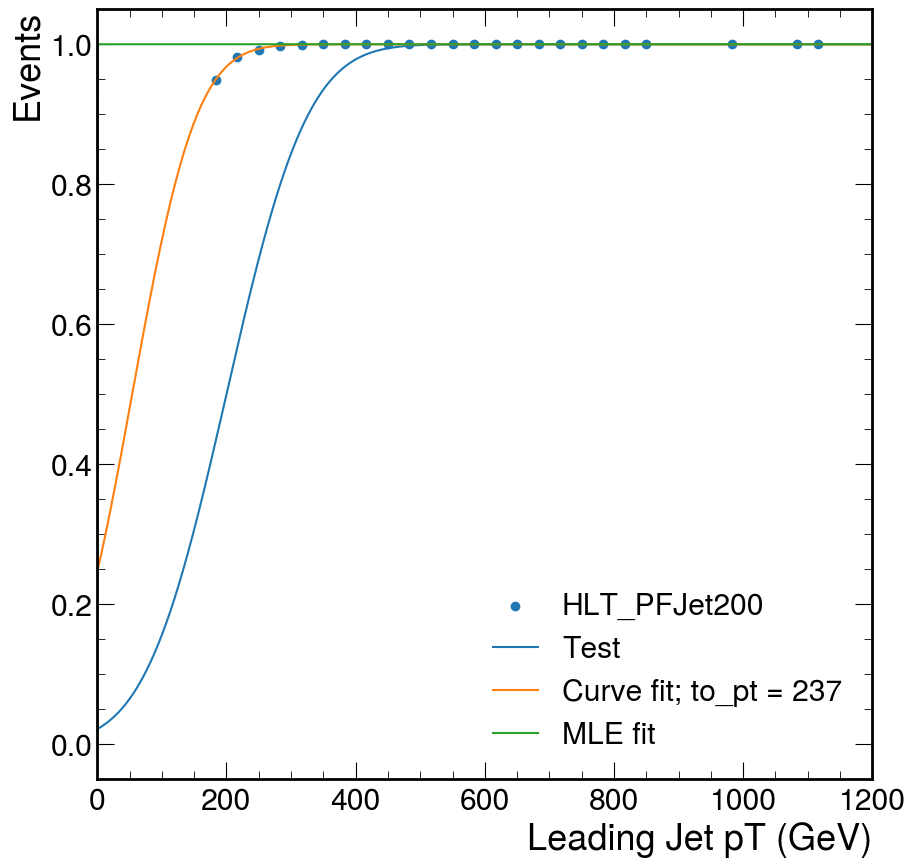

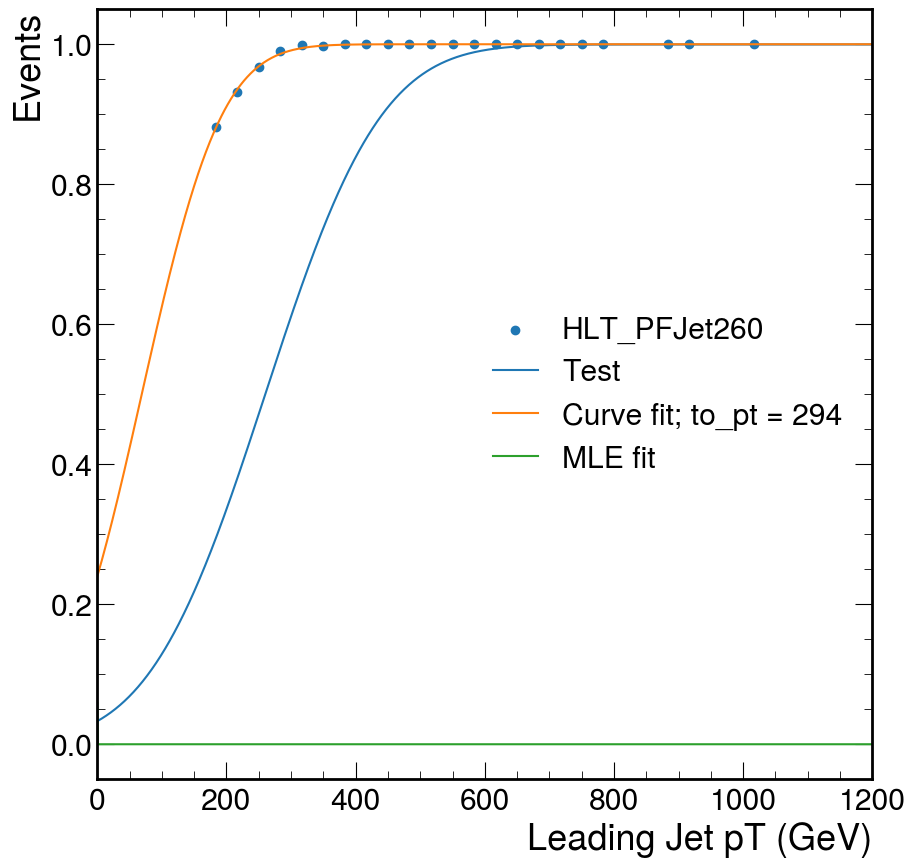

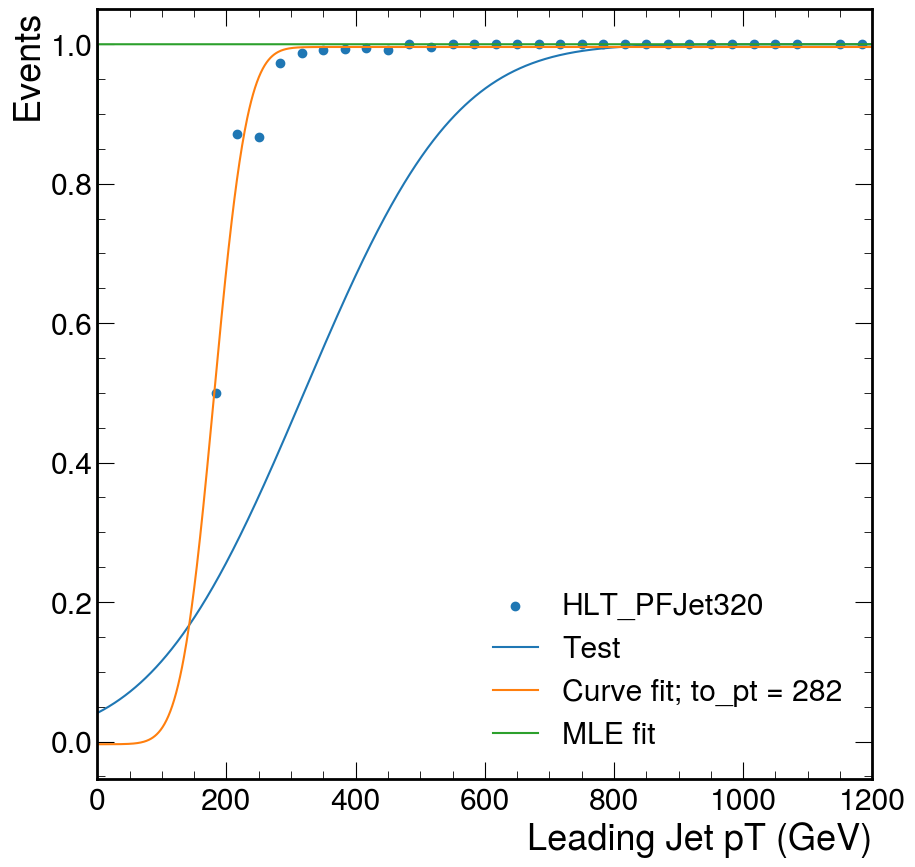

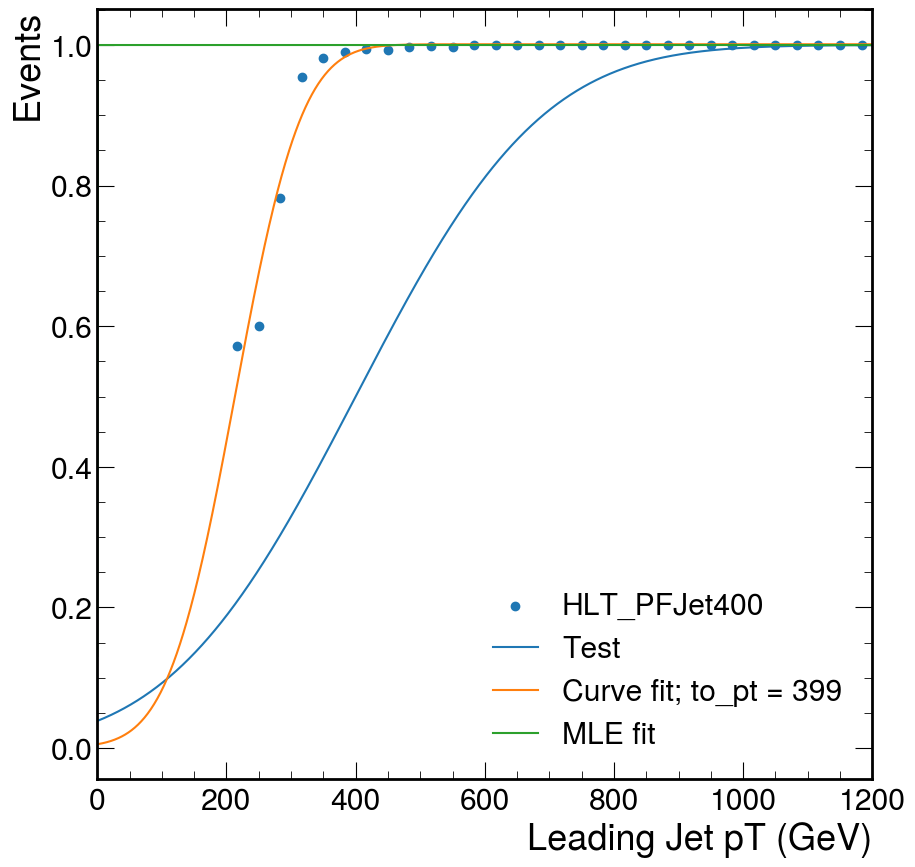

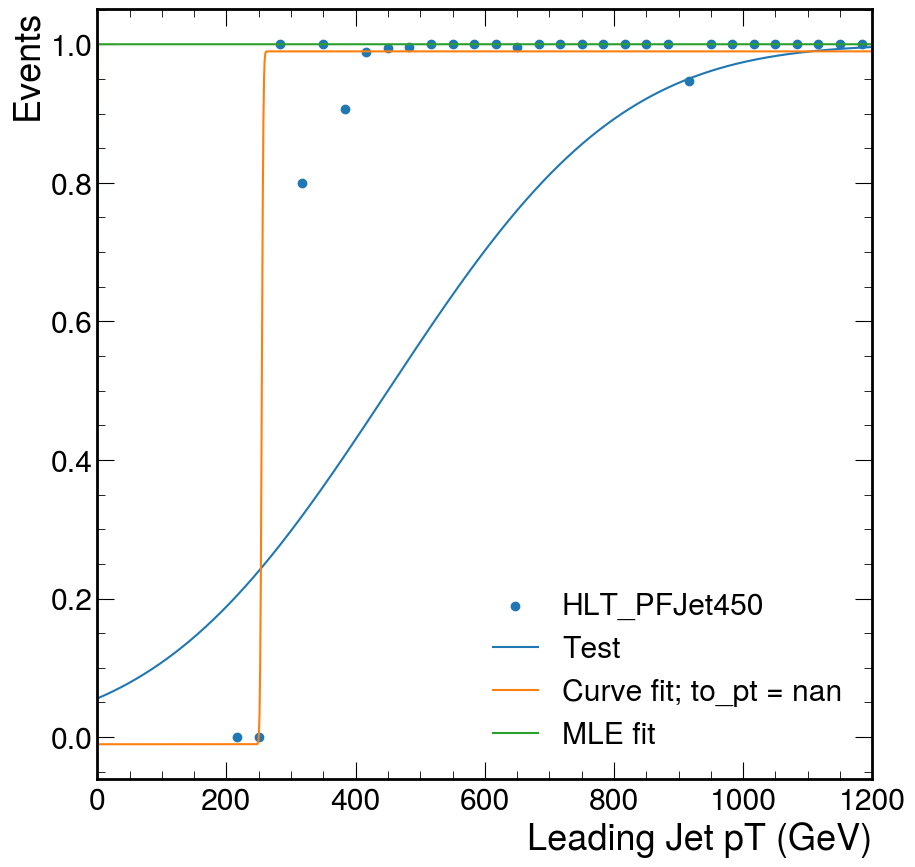

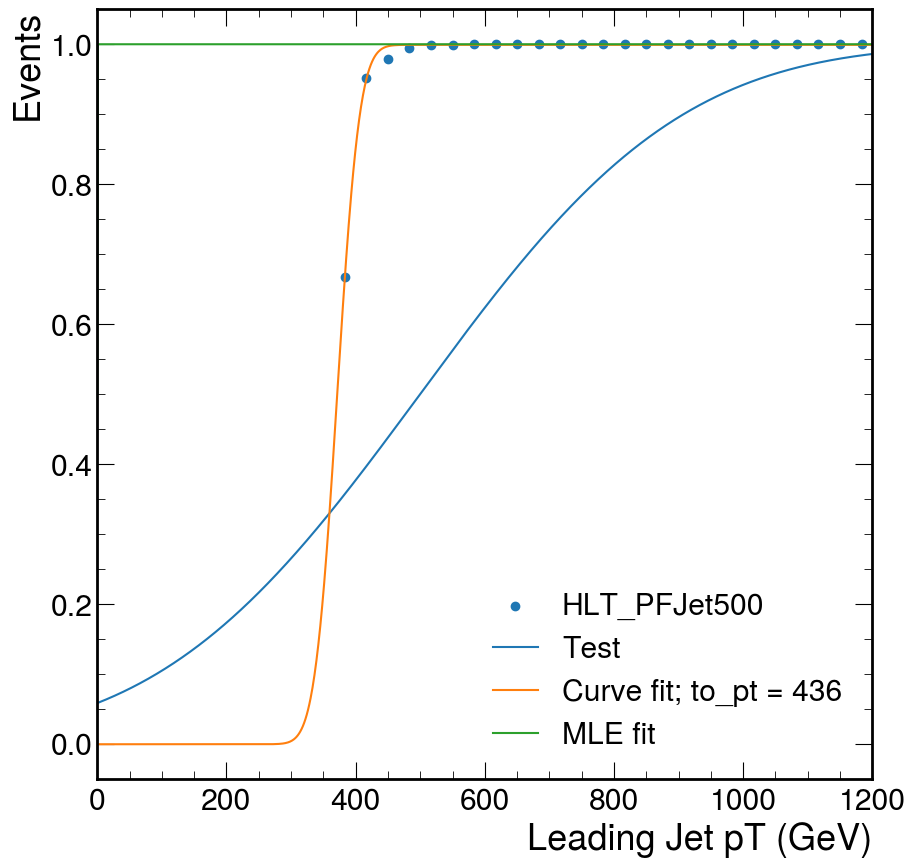

In [12]:
import matplotlib.pyplot as plt
from coffea import processor
from coffea import hist
# import hist
# from hist import Hist
plt.style.use([hep.style.CMS, hep.style.firamath])

####### MAKING TURN ON PLOTS

print(trigObj.pt)
print(len(trigObj.pt))
print(ak.sum(trigObj.pt, axis = -1))
print(ak.count(ak.sum(trigObj.pt, axis = -1)))

print(ak.sum(trigObj.pt, axis = -1) > 40.)
print(len(trigObj[ak.sum(trigObj.pt, axis = -1) > 60.]))

HLT_masks_2016 = {path : events.HLT[path] for path in list(prescale_2016.keys()) }
print(HLT_masks_2016)
efficiencies_2016 = {}

#need to find different way to map dataset category, but can keep HLT_cat as StrCategory axis
#Old coffea way using coffea.hist.Hist
hist_trigEff = hist.Hist("Events",
                         hist.Cat("dataset", "Dataset"),
                         hist.Cat("HLT_cat", ""),
                         hist.Bin("jet_pt", "Fat Jet pT (GeV)", 60, 0., 2000.),
                        )
hist_trigRef = hist.Hist("Events",
                         hist.Cat("dataset", "Dataset"),
                         hist.Cat("HLT_cat", ""),
                         hist.Bin("jet_pt", "Fat Jet pT (GeV)", 60, 0., 2000.),
                        )

#Transition from coffea.Hist to hist.Hist by december
# pt_axis = hist.axis.Regular(60, 0., 1200.,name = "jet_pt", label = "Fat Jet pT (GeV)")
# hist_trigEff = hist.Hist(hist.axis.StrCategory([], growth=True, name="HLT_cat", label="HLT_"), #add +path in function
#                          pt_axis,
#                          storage = "weight",
#                          name = "Events"
#                         )
# hist_trigRef = hist.Hist(hist.axis.StrCategory([], growth=True, name="HLT_cat", label="HLT_"), #add +path in function
#                          hist.axis.Regular(60, 0., 1200.,name = "jet_pt", label = "Fat Jet pT (GeV)"),
#                          storage = "weight",
#                          name = "Events"
#                  )

from scipy.optimize import minimize, curve_fit
from scipy.stats import rv_continuous
from scipy.special import erf, erfinv
def fit_function(x, a, b, c):
    y = a + 0.5*(1+erf((x-b)/c))
    return y


def negLL(params, x, data):
    #x is the pt bin centers, y is the fit
    y = fit_function(x, *params)
    negLL = -np.sum(-(data-y)**2/2)
    return negLL
                      
                      
def fit_trigEff(x, data):
    #x is the pt bin centers; data is the efficiency values
    bounds = ((None, None), (50., 500.), (50., 500.))
    x0 = [0., 200., 200.]
    popt, pcov = curve_fit(fit_function, x, data, p0 = x0)
    result = minimize(negLL, x0 = popt, args= (x, data), bounds = bounds)
    print("Basic fit results: ", popt)
    print("MLE results: ", result.get("jac"))
    return result.get("jac"), popt


# HOW DO YOU GET -- get what friend

efficiency_HLT60 = events.HLT['PFJet40'] & (ak.sum(trigObj.pt, axis = -1) > 40.) & (ak.sum(trigObj.pt, axis = -1) > 60.)
keys = list(prescale_2016.keys())
#fig, ax = plt.subplots(1, 1)
plt.rcParams['figure.facecolor']='white'
to_pt_2016 = {}
for i in np.arange(len(keys)):
    path = keys[i]
    print("index: ", i, " path: ", path)
    if i > 0:
        print(keys[i-1])
        print("HLT pt cut: ", trigThresh_2016[i-1], " L1 pt cut: ", trigThresh_2016[i])
        efficiencies_2016[path] = events.FatJet[:,0].pt[(events.HLT[keys[i-1]] & (ak.sum(trigObj.pt, axis = -1) > trigThresh_2016[i]) & (ak.sum(trigObj.l1pt, axis = -1) > trigThresh_2016[i-1]))]
        hist_trigEff.fill(dataset = "JetHT_2016", HLT_cat = path, jet_pt = efficiencies_2016[path])
        hist_trigRef.fill(dataset = "JetHT_2016", HLT_cat = path, jet_pt = events.FatJet[:,0].pt[(events.HLT[keys[i-1]])])
#         hist_trigEff.fill(HLT_cat = path, jet_pt = events.FatJet[:,0].pt[(events.HLT[keys[i]])])
#         hist_trigRef.fill(HLT_cat = path, jet_pt = events.FatJet[:,0].pt[(events.HLT[keys[i-1]])])
        
        #NEED TO PLOT RATIO FOR EACH HLT PATH
        
        numerator = hist_trigEff.sum('dataset').integrate('HLT_cat',path).values()[()]
#         numerator = hist_trigEff[{'HLT_cat': sum}].values()
        denominator = hist_trigRef.sum('dataset').integrate('HLT_cat',path).values()[()]
#         denominator = hist_trigRef[{'HLT_cat': sum}].values()
        print("Length of num:", len(numerator), " Length of denom: ", len(denominator))
        print(denominator)
        
        num = numerator[denominator > 0]
        denom = denominator[denominator > 0]
        print("Length of num:", len(num), " Length of denom: ", len(denom))

        

        efficiency = num / denom

        print("Number of bins:", len(hist_trigEff.axis('jet_pt').centers()))
#         print("Number of bin:", len(hist_trigEff.axes['jet_pt'].centers))
        print(hist_trigEff.to_hist())
#         print(hist_trigEff.to_numpy())
        print(hist_trigEff.axis('jet_pt').centers().flatten()[denominator > 0])
#         print(hist_trigEff.axes['jet_pt'].centers.flatten()[denominator > 0])
        
        print(efficiency)
        
        #### Make custom fit function for the efficiencies
        pt_centers = hist_trigEff.axis('jet_pt').centers()[denominator > 0]
        if len(efficiency > 0):
            fig, ax = plt.subplots(1, 1)
            ax.set_ylabel(hist_trigEff.integrate('HLT_cat',path).label)
            ax.set_xlim([0,1200])
            jac, popt = fit_trigEff(pt_centers, efficiency)
            xpts = np.linspace(0, 1200, 1200)
            print("Curve_fit: ", popt)
            ### turn on point is pt value when efficiency reaches 0.99 --> solve fitted equation
            a, b, c = popt
            to_pt = (c*erfinv(2*0.99-2*a-1)) + b
            to_pt_2016[path] = to_pt
#         ax.scatter(hist_trigEff.axes['jet_pt'].centers[denominator > 0], efficiency, label = 'HLT_' + path)
            ax.scatter(hist_trigEff.axis('jet_pt').centers()[denominator > 0], efficiency, label = 'HLT_' + path)
            ax.plot(xpts, 0.5*(1+erf((xpts-trigThresh_2016[i])/trigThresh_2016[i-1])), label = "Test")
            ax.plot(xpts, fit_function(xpts, *popt), label = "Curve fit; to_pt = %.f"%to_pt)
            ax.plot(xpts, fit_function(xpts, *jac), label = "MLE fit")
            ax.set_xlabel("Leading Jet pT (GeV)")
            ax.legend()

print(to_pt_2016)

#         numerator = hist_trigEff[{'HLT_cat': sum}]
#         denominator = hist_trigRef[{'HLT_cat': sum}]
#         numerator = hist_trigEff.integrate('HLT_cat',path)
#         denominator = hist_trigRef.integrate('HLT_cat',path)
        
#         hist.plotratio(
#             num=numerator,
#             denom=denominator, ax = ax,
#             error_opts={'color': 'k', 'marker': '.'},
#             unc='clopper-pearson'
#          )  

#Its ugly, but it works. NOW SCALE IT UP


In [13]:
#### TURN ON PLOTS -- THE SMART WAY
#### based on the trigger emulation method spelled out here https://cms.cern.ch/iCMS/jsp/db_notes/noteInfo.jsp?cmsnoteid=CMS%20AN-2015/154
class triggerProcessor(processor.ProcessorABC):
    def __init__(self, year = None):
        self.year = year
        dataset_cat = hist.Cat("dataset", "Dataset")
        HLT_cat = hist.Cat("HLT_cat", "")
        pt_bin = hist.Bin("pt", "Jet pT (GeV)", 60, 0, 2400)
        self._histos = processor.dict_accumulator({
            'hist_trigEff': hist.Hist("Events", dataset_cat, HLT_cat, pt_bin),
            'hist_trigRef': hist.Hist("Events", dataset_cat, HLT_cat, pt_bin),
            'cutflow':      processor.defaultdict_accumulator(int),
            })
    
    @property
    def accumulator(self):
        return self._histos
    def process(self, events):
        out = self.accumulator.identity()
    
#### Next run processor with futures executor on all test files --> if successful try dask executor

dict_values([140.0, 200.0, 260.0, 350.0, 460.0, 550.0, 650.0, 760.0, 760.0, 760.0])
9
bin edge for  PFJet500  is  760.0
8
bin edge for  PFJet450  is  760.0
7
650.0
[False, False, False, False, False, False, ... False, False, False, False, False]
[False, False, False, False, False, False, ... False, False, False, False, False]
bin edges for  PFJet400  are  650.0  and  760.0
6
550.0
[False, False, False, False, False, False, ... False, False, False, False, False]
[False, False, False, False, False, False, ... True, False, False, False, True, True]
bin edges for  PFJet320  are  550.0  and  650.0
5
460.0
[False, False, False, False, False, False, ... False, False, False, False, False]
[False, False, False, False, False, False, ... True, False, True, False, True, False]
bin edges for  PFJet260  are  460.0  and  550.0
4
350.0
[False, False, False, False, False, False, ... False, False, False, True, True]
[False, False, False, False, False, False, ... False, False, False, False, False]
bin ed

/opt/conda/lib/python3.8/site-packages/coffea/hist/plot.py:43: RuntimeWarning: All sumw are zero!  Cannot compute meaningful error bars
  warnings.warn(
/opt/conda/lib/python3.8/site-packages/coffea/hist/plot.py:43: RuntimeWarning: All sumw are zero!  Cannot compute meaningful error bars
  warnings.warn(
/opt/conda/lib/python3.8/site-packages/coffea/hist/plot.py:43: RuntimeWarning: All sumw are zero!  Cannot compute meaningful error bars
  warnings.warn(
/opt/conda/lib/python3.8/site-packages/coffea/hist/plot.py:43: RuntimeWarning: All sumw are zero!  Cannot compute meaningful error bars
  warnings.warn(
/opt/conda/lib/python3.8/site-packages/coffea/hist/plot.py:43: RuntimeWarning: All sumw are zero!  Cannot compute meaningful error bars
  warnings.warn(
/opt/conda/lib/python3.8/site-packages/coffea/hist/plot.py:43: RuntimeWarning: All sumw are zero!  Cannot compute meaningful error bars
  warnings.warn(


Text(0.5, 1.0, 'Doubles removed w/ prescale applied')

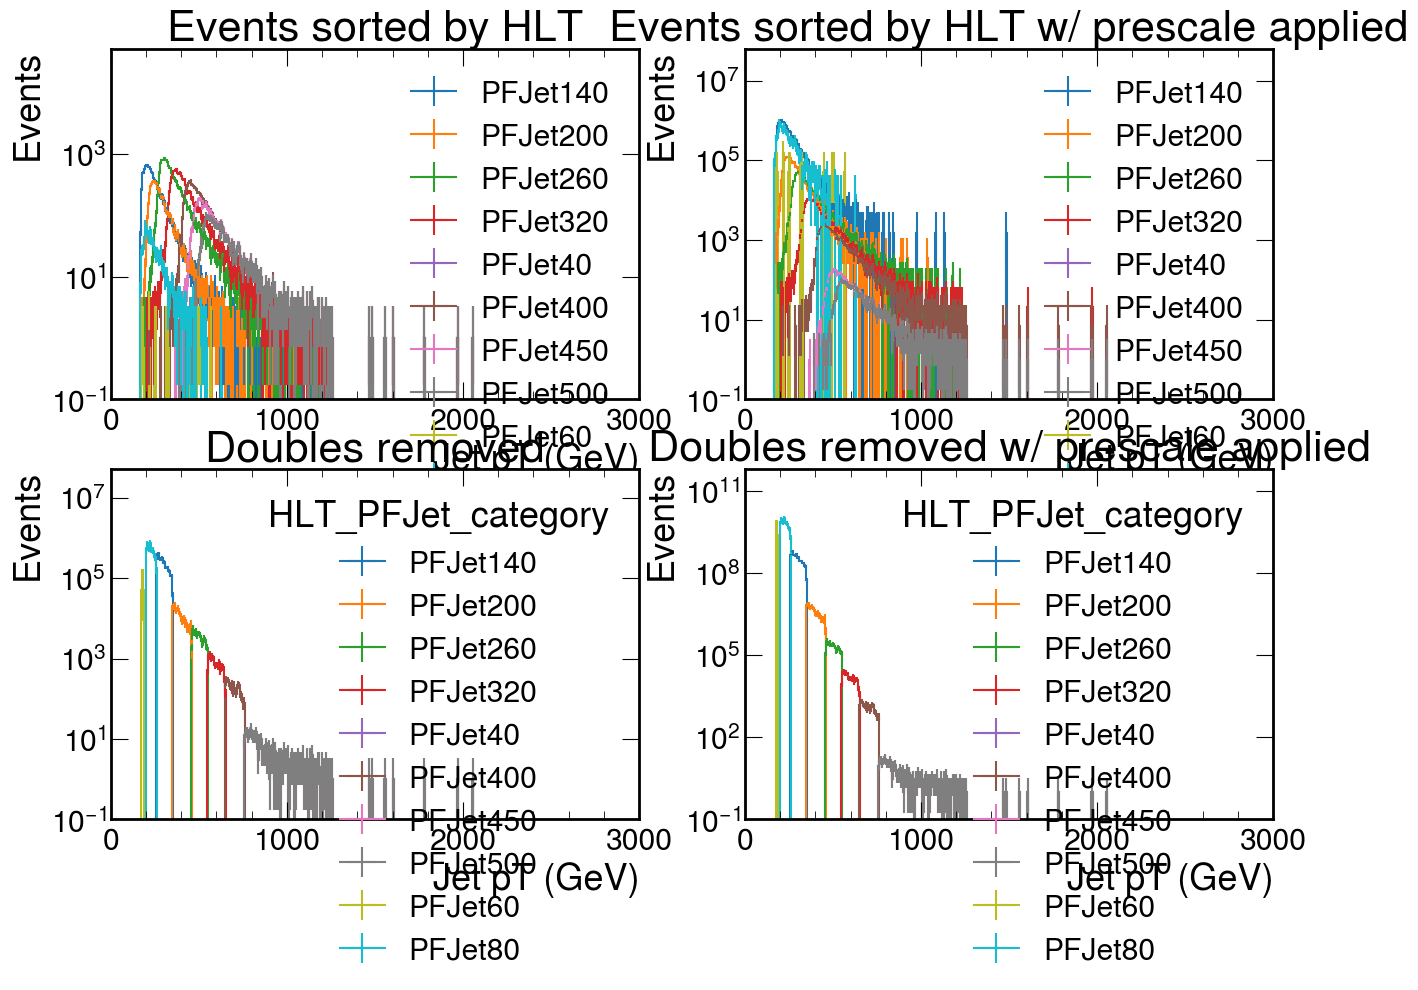

In [14]:
#### Sal pseudocode
# for path in prescale_2016: 
#     thesum = np.sum(events[path].array())
#     print("%20s : %10d" % (path, thesum) )

# def sortHLT_hists(prescale_dict):
%matplotlib inline
import matplotlib.pyplot as plt

HLT_masks = { }
HLT_masks_noDoubles = {}
HLT_masks_ptBinned = {}
print(pt_thresh_2016.values())
pt_bins_2016 = [0., 140.0, 200.0, 260.0, 350.0, 460.0, 550.0, 650.0, 760.0, 760.0, 3000.]
#current binning is lazy scatter
prescale_hist_16 = hist.Hist("Events",
                             hist.Cat("dataset", "Dataset"),
                             hist.Cat("HLT_cat", ""),
                             hist.Bin("jet_pt", "Jet pT (GeV)", 500, 0., 3000.),
                 )
prescale_hist_noDoubles_16 = hist.Hist("Events",
                             hist.Cat("dataset", "Dataset"),
                             hist.Cat("HLT_cat", "HLT_PFJet_category"),
                             hist.Bin("jet_pt", "Jet pT (GeV)", 500, 0., 3000.),
                 )
prescale_hist_ptBinned_16 = hist.Hist("Events",
                             hist.Cat("dataset", "Dataset"),
                             hist.Cat("HLT_cat", "HLT_PFJet_category"),
                             hist.Bin("jet_pt", "Jet pT (GeV)", 500, 0., 3000.),
                 )


##### make HLT_masks dictionary
for i in np.arange(len(keys))[::-1]:
    path = keys[i]
#     HLT_masks[path] = uprootevents[path].array()
    HLT_masks[path] = events.HLT[path]
#     print(np.sum(HLT_masks[path]))  
leadingjets = events.FatJet[:,0]

# change to pythonic --> use np.digitize
for i in np.arange(len(keys))[::-1]:
    print(i)
    path = keys[i]
    pt0 = events.FatJet[:,0].pt
#     print(pt0) #leading pt of each jet
    if i > 0 and prescale_2016[path] != 1.0:
            print(pt_thresh_2016[keys[i-1]])
            print((pt_thresh_2016[keys[i-1]] <= pt0) & (pt0 < pt_thresh_2016[path]))
            print(events.HLT[path])
            HLT_masks_noDoubles[path] = (events.HLT[path] & (pt_thresh_2016[keys[i-1]] <= pt0) & (pt0 < pt_thresh_2016[path]))
            print('bin edges for ', path, ' are ', pt_thresh_2016[keys[i-1]], ' and ', pt_thresh_2016[path])
    elif i > 0 and prescale_2016[path] == 1.0:
        print('bin edge for ', path, ' is ', pt_thresh_2016[keys[i-1]])
        HLT_masks_noDoubles[path] = (events.HLT[path] & (pt_thresh_2016[keys[i-1]] <= pt0))
    elif i == 0:
        print('bin edge for ', path, ' is ', pt_thresh_2016[path])
        HLT_masks_noDoubles[path] = (events.HLT[path] & ak.all(pt0 < pt_thresh_2016[path], axis = -1))
    else:
        break
#     print(np.sum(HLT_masks_noDoubles[path]))

##### hardcode get rid of doubles
# HLT_masks_noDoubles['PFJet500'] = HLT_masks['PFJet500']
# HLT_masks_noDoubles['PFJet450'] = HLT_masks['PFJet450'] & ~HLT_masks['PFJet500']
# HLT_masks_noDoubles['PFJet400'] = HLT_masks['PFJet400'] & ~HLT_masks['PFJet450'] & ~HLT_masks['PFJet500']
# HLT_masks_noDoubles['PFJet320'] = HLT_masks['PFJet320'] & ~HLT_masks['PFJet400'] & ~HLT_masks['PFJet450'] & ~HLT_masks['HLT_PFJet500']
# HLT_masks_noDoubles['PFJet260'] = HLT_masks['PFJet260'] & ~HLT_masks['PFJet320'] & ~HLT_masks['PFJet400'] & ~HLT_masks['HLT_PFJet450'] & ~HLT_masks['HLT_PFJet500']
# HLT_masks_noDoubles['PFJet200'] = HLT_masks['PFJet200'] & ~HLT_masks['PFJet260'] & ~HLT_masks['PFJet320'] & ~HLT_masks['HLT_PFJet400'] & ~HLT_masks['HLT_PFJet450'] & ~HLT_masks['HLT_PFJet500']
# HLT_masks_noDoubles['PFJet140'] = HLT_masks['PFJet140'] & ~HLT_masks['PFJet200'] & ~HLT_masks['PFJet260'] & ~HLT_masks['HLT_PFJet320'] & ~HLT_masks['HLT_PFJet400'] & ~HLT_masks['HLT_PFJet450'] & ~HLT_masks['HLT_PFJet500']
# HLT_masks_noDoubles['PFJet80'] = HLT_masks['PFJet80'] & ~HLT_masks['PFJet140'] & ~HLT_masks['PFJet200'] & ~HLT_masks['HLT_PFJet260'] & ~HLT_masks['HLT_PFJet320'] & ~HLT_masks['HLT_PFJet400'] & ~HLT_masks['HLT_PFJet450'] & ~HLT_masks['HLT_PFJet500']
# HLT_masks_noDoubles['PFJet60'] = HLT_masks['PFJet60'] & ~HLT_masks['PFJet80'] & ~HLT_masks['HLT_PFJet140'] & ~HLT_masks['HLT_PFJet200'] & ~HLT_masks['HLT_PFJet260'] & ~HLT_masks['HLT_PFJet320'] & ~HLT_masks['HLT_PFJet400'] & ~HLT_masks['HLT_PFJet450'] & ~HLT_masks['HLT_PFJet500']
# HLT_masks_noDoubles['PFJet40'] = HLT_masks['PFJet40'] & ~HLT_masks['PFJet60'] & ~HLT_masks['HLT_PFJet80'] & ~HLT_masks['HLT_PFJet140'] & ~HLT_masks['HLT_PFJet200'] & ~HLT_masks['HLT_PFJet260'] & ~HLT_masks['HLT_PFJet320'] & ~HLT_masks['HLT_PFJet400'] & ~HLT_masks['HLT_PFJet450'] & ~HLT_masks['HLT_PFJet500']
for path in HLT_masks:
    print("# of ", path, " events with doubles ", np.sum(HLT_masks[path]), "\n")
    print("# of ", path, " events WITHOUT doubles", np.sum(HLT_masks_noDoubles[path]), "\n")
    print("# of ", path, " events within pt bins", np.sum(HLT_masks_noDoubles[path]), "\n")
#### apply masks and fill hists
for path in keys[::-1]:
    if path in events.HLT.fields:
        fatjets = leadingjets[events.HLT[path]]
        fatjets_noDoubles = leadingjets[HLT_masks_noDoubles[path]]
        fatjets_ptBinned = leadingjets[HLT_masks_noDoubles[path]]
        prescale_hist_16.fill(dataset = "JetHT_2016", HLT_cat = path, jet_pt = fatjets.pt)
        prescale_hist_noDoubles_16.fill(dataset = "JetHT_2016", HLT_cat = path, jet_pt = fatjets_noDoubles.pt)
        prescale_hist_ptBinned_16.fill(dataset = "JetHT_2016", HLT_cat = path, jet_pt = fatjets_ptBinned.pt)    
    else:
        print(path, ' not in collection, moving to next path -- years are likely mismatched')
        
plt.rcParams['figure.facecolor']='white'
plt.rcParams["figure.figsize"] = (15,10)
fig, axs = plt.subplots(2, 2)

print("Check for none values", ak.any(ak.is_none(fatjets.pt, axis = -1)))
        
# print(np.isnan(prescale_hist_16))
    
hist.plot1d(prescale_hist_16.sum('dataset'), ax = axs[0,0], overlay='HLT_cat')
axs[0,0].set_yscale('log')
axs[0,0].set_ylim([1.0e-1, 5.0e4])
axs[0,0].set_title('Events sorted by HLT')

prescale_hist_16.scale(prescale_2016, axis = 'HLT_cat')

hist.plot1d(prescale_hist_16.sum('dataset'), ax = axs[0,1], overlay='HLT_cat')
axs[0,1].set_yscale('log')
axs[0,1].set_ylim([1.0e-1, 6.0e7])
axs[0,1].set_title('Events sorted by HLT w/ prescale applied')

hist.plot1d(prescale_hist_noDoubles_16.sum('dataset'), ax = axs[1,0], overlay='HLT_cat')
axs[1,0].set_yscale('log')
axs[1,0].set_ylim([1.0e-1, 5.0e4])
axs[1,0].set_title('Doubles removed')

prescale_hist_noDoubles_16.scale(prescale_2016, axis = 'HLT_cat')

hist.plot1d(prescale_hist_noDoubles_16.sum('dataset'), ax = axs[1,1], overlay='HLT_cat')
axs[1,1].set_yscale('log')
axs[1,1].set_ylim([1.0e-1, 6.0e7])
axs[1,1].set_title('Doubles removed w/ prescale applied')

hist.plot1d(prescale_hist_noDoubles_16.sum('dataset'), ax = axs[1,0], overlay='HLT_cat')
axs[1,0].set_yscale('log')
axs[1,0].set_ylim([1.0e-1, 5.0e7])
axs[1,0].set_title('Doubles removed')

prescale_hist_noDoubles_16.scale(prescale_2016, axis = 'HLT_cat')

hist.plot1d(prescale_hist_noDoubles_16.sum('dataset'), ax = axs[1,1], overlay='HLT_cat')
axs[1,1].set_yscale('log')
axs[1,1].set_ylim([1.0e-1, 6.0e11])
axs[1,1].set_title('Doubles removed w/ prescale applied')

In [15]:
# HLT_masks_noDoubles['PFJet500'] = HLT_masks['PFJet500']
# HLT_masks_noDoubles['PFJet450'] = HLT_masks['PFJet450'] & ~HLT_masks['PFJet500']
# HLT_masks_noDoubles['PFJet400'] = HLT_masks['PFJet400'] & ~HLT_masks['PFJet450'] & ~HLT_masks['PFJet500']
# HLT_masks_noDoubles['PFJet320'] = HLT_masks['PFJet320'] & ~HLT_masks['PFJet400'] & ~HLT_masks['PFJet450'] & ~HLT_masks['HLT_PFJet500']
# HLT_masks_noDoubles['PFJet260'] = HLT_masks['PFJet260'] & ~HLT_masks['PFJet320'] & ~HLT_masks['PFJet400'] & ~HLT_masks['HLT_PFJet450'] & ~HLT_masks['HLT_PFJet500']
# HLT_masks_noDoubles['PFJet200'] = HLT_masks['PFJet200'] & ~HLT_masks['PFJet260'] & ~HLT_masks['PFJet320'] & ~HLT_masks['HLT_PFJet400'] & ~HLT_masks['HLT_PFJet450'] & ~HLT_masks['HLT_PFJet500']
# HLT_masks_noDoubles['PFJet140'] = HLT_masks['PFJet140'] & ~HLT_masks['PFJet200'] & ~HLT_masks['PFJet260'] & ~HLT_masks['HLT_PFJet320'] & ~HLT_masks['HLT_PFJet400'] & ~HLT_masks['HLT_PFJet450'] & ~HLT_masks['HLT_PFJet500']
# HLT_masks_noDoubles['PFJet80'] = HLT_masks['PFJet80'] & ~HLT_masks['PFJet140'] & ~HLT_masks['PFJet200'] & ~HLT_masks['HLT_PFJet260'] & ~HLT_masks['HLT_PFJet320'] & ~HLT_masks['HLT_PFJet400'] & ~HLT_masks['HLT_PFJet450'] & ~HLT_masks['HLT_PFJet500']
# HLT_masks_noDoubles['PFJet60'] = HLT_masks['PFJet60'] & ~HLT_masks['PFJet80'] & ~HLT_masks['HLT_PFJet140'] & ~HLT_masks['HLT_PFJet200'] & ~HLT_masks['HLT_PFJet260'] & ~HLT_masks['HLT_PFJet320'] & ~HLT_masks['HLT_PFJet400'] & ~HLT_masks['HLT_PFJet450'] & ~HLT_masks['HLT_PFJet500']
# HLT_masks_noDoubles['PFJet40'] = HLT_masks['PFJet40'] & ~HLT_masks['PFJet60'] & ~HLT_masks['HLT_PFJet80'] & ~HLT_masks['HLT_PFJet140'] & ~HLT_masks['HLT_PFJet200'] & ~HLT_masks['HLT_PFJet260'] & ~HLT_masks['HLT_PFJet320'] & ~HLT_masks['HLT_PFJet400'] & ~HLT_masks['HLT_PFJet450'] & ~HLT_masks['HLT_PFJet500']
